In [31]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import datetime
import time
from keras import layers, optimizers
from keras.preprocessing import image
from keras.models import Sequential,load_model                         # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer 
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping   # Classes used to save weights and stop training when improvements reach a limit

# Importing TensorFlow
import tensorflow as tf
from tensorflow.keras.utils import load_img 
from tensorflow.keras.callbacks import TensorBoard

from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import classification_report, confusion_matrix
# balance classes 
from sklearn.utils import class_weight

In [32]:
data_dir = r"C:\Users\marak\Downloads\Data"
train_dir = r"C:\Users\marak\Downloads\Data\train"
val_dir = r"C:\Users\marak\Downloads\Data\valid"
test_dir = r"C:\Users\marak\Downloads\Data\test"

In [33]:
def rename_folder(dir_path):
    os.rename(os.path.join(dir_path, "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"),
             os.path.join(dir_path,'squamous.cell.carcinoma'))

    os.rename(os.path.join(dir_path, "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"),
             os.path.join(dir_path, 'adenocarcinoma'))
    
    os.rename(os.path.join(dir_path, "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"),
             os.path.join(dir_path, 'large.cell.carcinoma'))

rename_folder(val_dir)
rename_folder(train_dir)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\marak\\Downloads\\Data\\valid\\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa' -> 'C:\\Users\\marak\\Downloads\\Data\\valid\\squamous.cell.carcinoma'

In [34]:
classes = ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

## Load a Dataset

In [35]:
def load_dataset(dir):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir,
        labels = "inferred",
        label_mode = 'categorical',
        class_names = classes,
        color_mode='rgb',
        batch_size=32,
        image_size = (256,256),
        shuffle = True,
        crop_to_aspect_ratio = True #змінить розмір зображення без спотворення співвідношення сторін.
    ) 
    return ds

In [36]:
train_ds = load_dataset(train_dir)
test_ds = load_dataset(test_dir) 
val_ds = load_dataset(val_dir)  

print('\nTraining Dataset:', train_ds)
print('\nTesting Dataset:',  test_ds)
print('\nValidation Dataset:', val_ds)

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.

Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [37]:
classes

['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

## Visualize the Data

In [38]:
def visualise(dataset):
    plt.figure(figsize = (8,5), facecolor='lightseagreen')
    
    for img, labels in dataset.take(1):
        for i in range(3):
            ax = plt.subplot(1, 3, i+1)
            plt.imshow((img[i]).numpy().astype('uint8'))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(classes[label_index])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

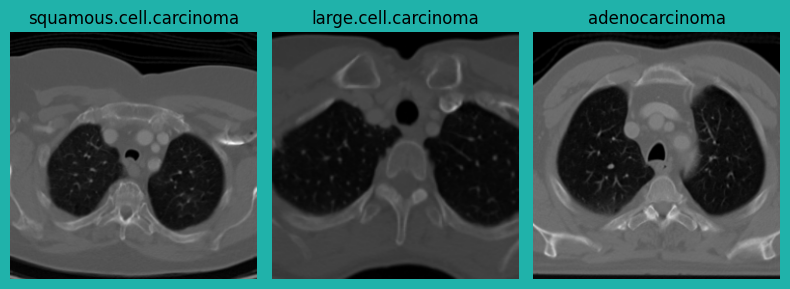

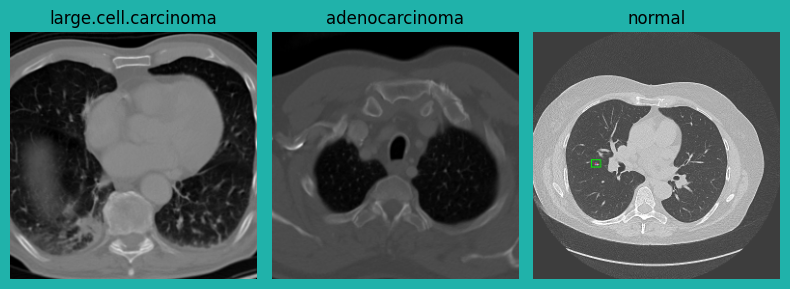

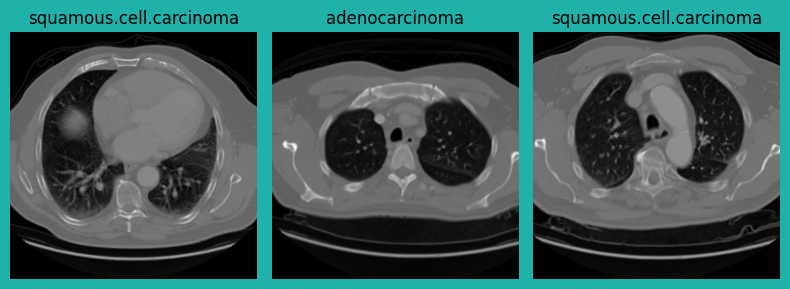

In [39]:
visualise(train_ds)
visualise(val_ds)
visualise(test_ds)

## Data Preprocessing


In [40]:
for img, labels in train_ds:
    print(img.shape)
    print(labels.shape)
    break

(32, 256, 256, 3)
(32, 4)


In [41]:
labels = []
for c in classes:
    print(f"{c}: {len(os.listdir(os.path.join(train_dir, c)))}")
    labels += [c] * len(os.listdir(os.path.join(train_dir, c)))

normal: 148
adenocarcinoma: 195
large.cell.carcinoma: 115
squamous.cell.carcinoma: 155


In [42]:
for c in classes:
    print((os.path.join(train_dir, c)))

C:\Users\marak\Downloads\Data\train\normal
C:\Users\marak\Downloads\Data\train\adenocarcinoma
C:\Users\marak\Downloads\Data\train\large.cell.carcinoma
C:\Users\marak\Downloads\Data\train\squamous.cell.carcinoma


In [43]:
# compute class weight 
# based on appearance of each class in y_trian
cls_wgts = class_weight.compute_class_weight(class_weight = 'balanced',
                                             classes = np.arange(len(classes)),
                                             y = np.array([classes.index(l) for l in labels]))

cls_wgts = dict(enumerate(cls_wgts))

In [44]:
cls_wgts

{0: 1.035472972972973,
 1: 0.7858974358974359,
 2: 1.3326086956521739,
 3: 0.9887096774193549}

In [45]:
# normalization_layer = layers.Rescaling(1./255)

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) #val_ds = val_ds.map(lambda x,y: (x/255, y))

##  Data Augmentation

In [46]:
data_augmentation = tf.keras.Sequential([
  #layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)])

adenocarcinoma


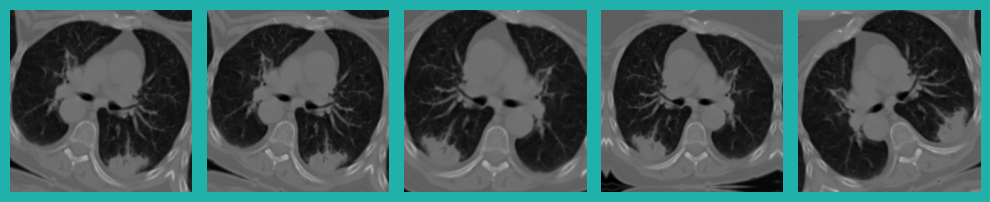

In [47]:
plt.figure(figsize = (10,10), facecolor = 'lightseagreen')
for img, label in train_ds.take(1):
    for i in range(5):
        augmented_img = data_augmentation(img, training = True)
        ax = plt.subplot(1,5, i+1)
        plt.imshow(augmented_img[0].numpy().astype('uint8'))
        plt.axis('off')
    label_index = tf.argmax(label[0]).numpy()
    print(f'{classes[label_index]}')
    plt.tight_layout()
    plt.show()

In [48]:
# applyind data augmentation to a dataset 
#(data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model)

train_ds = train_ds.map(lambda img, label: (data_augmentation(img, training=True), label),
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Early Stopping

In [49]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3, 
                               restore_best_weights=True) 

## Model Checkpoint

In [100]:
checkpoint_filepath = '/tmp/ckpt/best_model.keras'

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Model Creation 

In [51]:
def performance_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(7, 6), facecolor='lightseagreen')

    plt.subplot(2,1,1)
    plt.plot(acc,  label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

In [52]:
def cnn_model():
    model = Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Rescaling(1./255),
  
        layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        #layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        #layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        #layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        #layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation = 'relu'),
        #layers.Dropout(0.3),
        layers.Dense(4, activation = 'softmax')])
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer = optimizers.Adam(learning_rate=0.0001),
                  metrics = ['accuracy',
                             tf.keras.metrics.Precision(name="precision"),
                             tf.keras.metrics.Recall(name="recall"),
                             tf.keras.metrics.F1Score(name='f1_score', average='micro'),
                             tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

In [319]:
performance = []

model = cnn_model()

# Set up TensorBoard callback
logdir = os.path.join("logs", "cnn_model" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

start_time = time.time()

history = model.fit(train_ds, 
                    epochs = 25, 
                    validation_data = val_ds, 
                    verbose = 1,
                    class_weight = cls_wgts,
                    callbacks = [early_stopping, model_checkpoint, tensorboard_callback])

end_time = time.time() - start_time

val_loss, val_accuracy, val_precision, val_recall, val_f1, val_auc = model.evaluate(val_ds, verbose=1)

print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}%')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation Recall: {val_recall:.2f}')
print(f'Validation F1-Score: {val_f1:.2f}')
print(f'Validation AUC: {val_auc:.2f}')
performance.append([val_loss, val_accuracy, val_precision, val_recall, val_f1, val_auc, round(end_time,2)])

df_performance = pd.DataFrame(performance, columns = ['Val Loss','Val Acc', 'Val Precision','Val Recall','Val F1-score', 'Val AUC', 'Time'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_298 (Conv2D)                  │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_299 (Conv2D)                  │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_300 (Conv2D)                  │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_301 (Conv2D)                  │ (None, 30, 30, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,135,300 (57.74 MB)

 Trainable params: 15,135,300 (57.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2664 - auc: 0.5881 - f1_score: 0.2664 - loss: 1.3524 - precision: 0.6593 - recall: 0.0301 - val_accuracy: 0.1944 - val_auc: 0.5857 - val_f1_score: 0.1944 - val_loss: 1.2928 - val_precision: 1.0000 - val_recall: 0.1111
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3517 - auc: 0.6677 - f1_score: 0.3517 - loss: 1.2829 - precision: 0.9421 - recall: 0.0894 - val_accuracy: 0.2639 - val_auc: 0.6373 - val_f1_score: 0.2639 - val_loss: 1.2173 - val_precision: 0.8667 - val_recall: 0.1806
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4778 - auc: 0.7549 - f1_score: 0.4778 - loss: 1.1366 - precision: 0.8934 - recall: 0.1872 - val_accuracy: 0.5139 - val_auc: 0.8128 - val_f1_score: 0.5139 - val_loss: 0.9801 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6149 - auc: 0.8403 - f1_score: 0.6149 - loss: 0.9834 - precision: 0.8566 - recall: 0.2811 

In [320]:
df_performance

Val Loss   Val Acc  Val Precision  Val Recall  Val F1-score   Val AUC  \
0  0.704173  0.736111       0.761905    0.666667      0.736111  0.912166   

     Time  
0  445.63

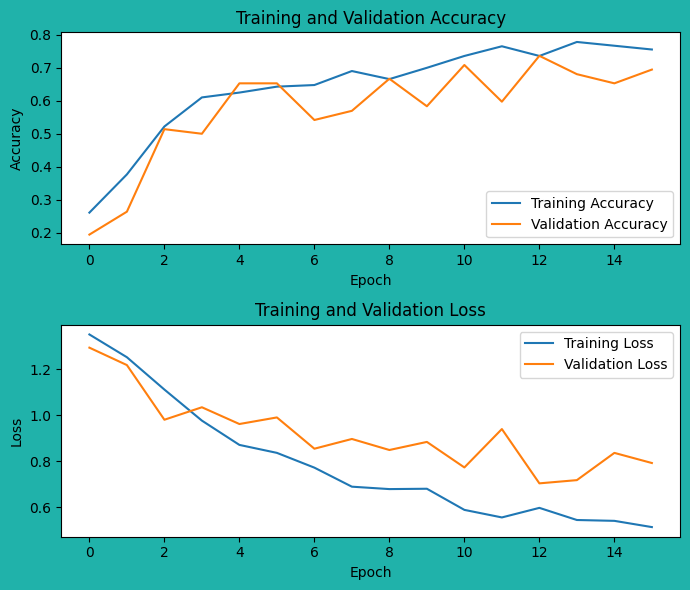

In [321]:
performance_plot(history)

## Transfer Learning

The process to use a pre-trained model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers: the layers to freeze are adjusted depending on similarity of new task to original dataset
3. Replace the upper layers of the network with a custom classifier: the number of outputs must be set equal to the number of classes
4. Train only the custom classifier layers for the task thereby optimizing the model for smaller dataset

* Завантажити попередньо навченi ваги. Iмпортувати ваги, отриманi пiд час
навчання обраних глибоких моделей на наборi зображень ImageNet.
* Побудувати один або кiлька верхнiх повнозв’язних шарiв. Останнiм (результуючим) шаром мережi має бути повнозв’язний softmax-шар з кiлькiстю нейронiв, яка дорiвнює кiлькостi класiв в заданому за варiантом наборi даних.
* Заморозити попередньо навченi ваги. Заморожуючи змiннi попередньої моделi ми гарантуємо, що буде навчатися тiльки один (кiлька) верхнiх повнозв’язних шарiв; значення попередньої моделi залишаться незмiнними.
* Виконати донавчання доданих верхнiх шарiв на власному наборi зображень.
* Налаштувати параметри доданих верхнiх шарiв на валiдацiйнiй пiдмножинi.

VGG19, Xception, InceptionV3, ResNet152, DenseNet201,EfficientNetB7.

In [53]:
from keras.models import Model
from keras.applications import Xception, VGG16, ResNet50, InceptionV3, DenseNet121, ConvNeXtTiny,EfficientNetV2L 

In [54]:
def load_set(dir):
    dataAugmentaion = tf.keras.preprocessing.image.ImageDataGenerator(
                                     rescale = 1./255,
                                     horizontal_flip = True,
                                     zoom_range = 0.1,
                                     rotation_range=0.1)
    
    ds = dataAugmentaion.flow_from_directory(dir,
                                            target_size = (256, 256),
                                            batch_size=32,
                                            class_mode = 'categorical')
    return ds

In [55]:
train_set = load_set(train_dir)
test_set = load_set(test_dir) 
val_set = load_set(val_dir)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [56]:
def base_model(pre_model):
    print(f'Pre-trained model: {pre_model.output.shape}')
    # Freezed layers thatthey don’t change during training
    for layer in pre_model.layers:
        layer.trainable = False

    X = pre_model.output
    X = Flatten()(X)
    X = BatchNormalization()(X)
    X = Dense(128, activation = 'relu')(X)
    X_output =  Dense(4, activation = 'softmax')(X)
    
    model = Model(inputs = pre_model.input, outputs = X_output)

    model.compile(loss = 'categorical_crossentropy',
                       optimizer = optimizers.Adam(learning_rate=0.0001),
                       metrics = ['accuracy',
                             tf.keras.metrics.Precision(name="precision"),
                             tf.keras.metrics.Recall(name="recall"),
                             tf.keras.metrics.F1Score(name='f1_score', average='micro'),
                             tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

In [97]:
def train_model(model_base, train_set, val_set):
    # Set up TensorBoard callback
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    history = model_base.fit(train_set,
                             validation_data = val_set,
                             # validation_steps = len(val_set),
                             # steps_per_epoch  = len(train_set),
                             class_weight = cls_wgts,
                             callbacks = [early_stopping, model_checkpoint,tensorboard_callback],
                             verbose = 1,
                             epochs = 10)
    return history

In [58]:
pretrained_performance_val = []
pretrained_performance_test = []

### Xception Model

In [59]:
xc = Xception(
    include_top=False, #the final dense layer of the pre-trained model wasn’t included
    weights="imagenet",
    input_shape=(256, 256, 3),
    classes=4,
    pooling = 'avg',
    classifier_activation="softmax",
    name="xception")

xc_model = base_model(xc)

start_time = time.time()
xc_history = train_model(xc_model, train_set, val_set)
end_time = time.time() - start_time

Pre-trained model: (None, 2048)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 127, 127, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 127, 127, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 127, 127, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 125, 125, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 125, 125, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 125, 125, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 125, 125, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 125, 125, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 125, 125, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 125, 125, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 125, 125, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 63, 63, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 63, 63, 128)       │               

 Total params: 21,132,460 (80.61 MB)

 Trainable params: 266,884 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

C:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3905 - auc: 0.6261 - f1_score: 0.3905 - loss: 1.4840 - precision: 0.4592 - recall: 0.2497

20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3938 - auc: 0.6299 - f1_score: 0.3938 - loss: 1.4739 - precision: 0.4625 - recall: 0.2525 - val_accuracy: 0.3750 - val_auc: 0.6418 - val_f1_score: 0.3750 - val_loss: 1.2585 - val_precision: 1.0000 - val_recall: 0.1389
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5876 - auc: 0.8393 - f1_score: 0.5876 - loss: 0.8967 - precision: 0.6482 - recall: 0.4619

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5889 - auc: 0.8401 - f1_score: 0.5889 - loss: 0.8944 - precision: 0.6502 - recall: 0.4637 - val_accuracy: 0.5556 - val_auc: 0.7876 - val_f1_score: 0.5556 - val_loss: 1.1598 - val_precision: 1.0000 - val_recall: 0.1389
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6707 - auc: 0.8899 - f1_score: 0.6707 - loss: 0.7524 - precision: 0.7263 - recall: 0.5753

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6706 - auc: 0.8900 - f1_score: 0.6706 - loss: 0.7518 - precision: 0.7269 - recall: 0.5750 - val_accuracy: 0.4722 - val_auc: 0.7796 - val_f1_score: 0.4722 - val_loss: 1.1464 - val_precision: 1.0000 - val_recall: 0.1111
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7227 - auc: 0.9212 - f1_score: 0.7227 - loss: 0.6391 - precision: 0.8053 - recall: 0.6189

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7218 - auc: 0.9209 - f1_score: 0.7218 - loss: 0.6403 - precision: 0.8045 - recall: 0.6183 - val_accuracy: 0.5139 - val_auc: 0.8146 - val_f1_score: 0.5139 - val_loss: 1.0894 - val_precision: 1.0000 - val_recall: 0.1806
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7666 - auc: 0.9345 - f1_score: 0.7666 - loss: 0.5846 - precision: 0.8110 - recall: 0.6488

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7667 - auc: 0.9348 - f1_score: 0.7667 - loss: 0.5837 - precision: 0.8115 - recall: 0.6495 - val_accuracy: 0.5694 - val_auc: 0.8427 - val_f1_score: 0.5694 - val_loss: 1.0356 - val_precision: 1.0000 - val_recall: 0.1667
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8216 - auc: 0.9631 - f1_score: 0.8216 - loss: 0.4713 - precision: 0.8867 - recall: 0.7564

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8210 - auc: 0.9628 - f1_score: 0.8210 - loss: 0.4721 - precision: 0.8861 - recall: 0.7557 - val_accuracy: 0.5694 - val_auc: 0.8414 - val_f1_score: 0.5694 - val_loss: 1.0182 - val_precision: 0.8333 - val_recall: 0.2083
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8327 - auc: 0.9624 - f1_score: 0.8327 - loss: 0.4672 - precision: 0.8773 - recall: 0.7464

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8326 - auc: 0.9625 - f1_score: 0.8326 - loss: 0.4667 - precision: 0.8775 - recall: 0.7465 - val_accuracy: 0.5694 - val_auc: 0.8512 - val_f1_score: 0.5694 - val_loss: 0.9893 - val_precision: 0.8889 - val_recall: 0.2222
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8458 - auc: 0.9706 - f1_score: 0.8458 - loss: 0.4230 - precision: 0.9005 - recall: 0.7772

20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8452 - auc: 0.9705 - f1_score: 0.8452 - loss: 0.4234 - precision: 0.8996 - recall: 0.7767 - val_accuracy: 0.5694 - val_auc: 0.8642 - val_f1_score: 0.5694 - val_loss: 0.9443 - val_precision: 0.9474 - val_recall: 0.2500
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8569 - auc: 0.9754 - f1_score: 0.8569 - loss: 0.3953 - precision: 0.8872 - recall: 0.8035

20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8569 - auc: 0.9754 - f1_score: 0.8569 - loss: 0.3952 - precision: 0.8876 - recall: 0.8036 - val_accuracy: 0.6389 - val_auc: 0.8924 - val_f1_score: 0.6389 - val_loss: 0.8710 - val_precision: 0.8929 - val_recall: 0.3472
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8768 - auc: 0.9821 - f1_score: 0.8768 - loss: 0.3477 - precision: 0.9216 - recall: 0.8234

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8773 - auc: 0.9821 - f1_score: 0.8773 - loss: 0.3478 - precision: 0.9211 - recall: 0.8239 - val_accuracy: 0.6667 - val_auc: 0.8936 - val_f1_score: 0.6667 - val_loss: 0.8440 - val_precision: 0.8788 - val_recall: 0.4028


Validation Loss: 0.86 | Test Loss: 0.86
Validation Accuracy: 73.61% | Test Accuracy: 66.03%
Train Time: 500.057817697525


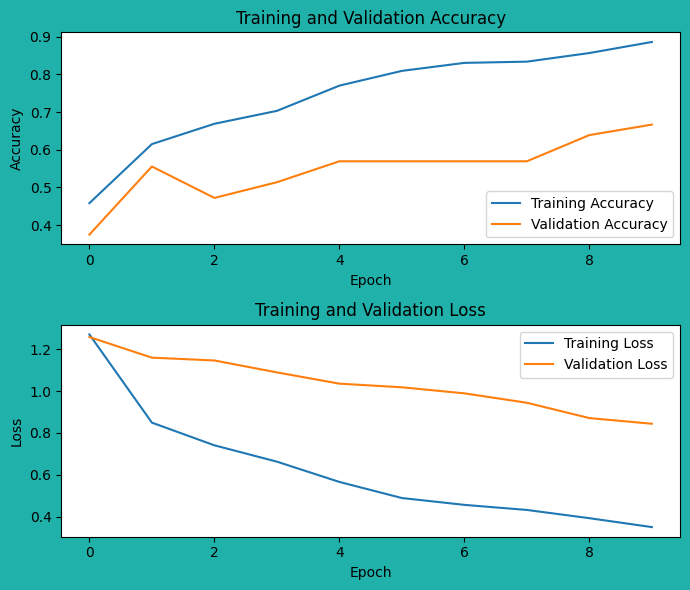

In [60]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = xc_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc = xc_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['Xception', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, end_time])
pretrained_performance_test.append(['Xception', test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc, end_time])

print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {end_time}')

performance_plot(xc_history)

### VGG16 Model

In [61]:
vgg16 = VGG16(include_top = False,
              input_shape = (256,256, 3),
              weights="imagenet",
              classes=4,
              pooling = 'avg',
              classifier_activation="softmax",
              name="vgg16")

vgg16_model = base_model(vgg16)

start_time = time.time()
vgg16_history = train_model(vgg16_model, train_set, val_set)
vgg16_time = time.time() - start_time

Pre-trained model: (None, 512)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │              

 Total params: 14,782,916 (56.39 MB)

 Trainable params: 67,204 (262.52 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.2989 - auc: 0.5189 - f1_score: 0.2989 - loss: 1.6004 - precision: 0.2819 - recall: 0.0786 - val_accuracy: 0.3472 - val_auc: 0.5750 - val_f1_score: 0.3472 - val_loss: 1.5046 - val_precision: 1.0000 - val_recall: 0.0139
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.4732 - auc: 0.7621 - f1_score: 0.4732 - loss: 1.1095 - precision: 0.6468 - recall: 0.2682 - val_accuracy: 0.4583 - val_auc: 0.6010 - val_f1_score: 0.4583 - val_loss: 1.4481 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5386 - auc: 0.8049 - f1_score: 0.5386 - loss: 1.0023 - precision: 0.7317 - recall: 0.3172 - val_accuracy: 0.4861 - val_auc: 0.6162 - val_f1_score: 0.4861 - val_loss: 1.3986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5803 - auc: 0.8420 - f1_score: 0.5803 - loss: 0.9143 - precision: 0.7720 -

Validation Loss: 1.14 | Test Loss: 1.17
Validation Accuracy: 51.39% | Test Accuracy: 54.92%
Train Time: 883.5969700813293


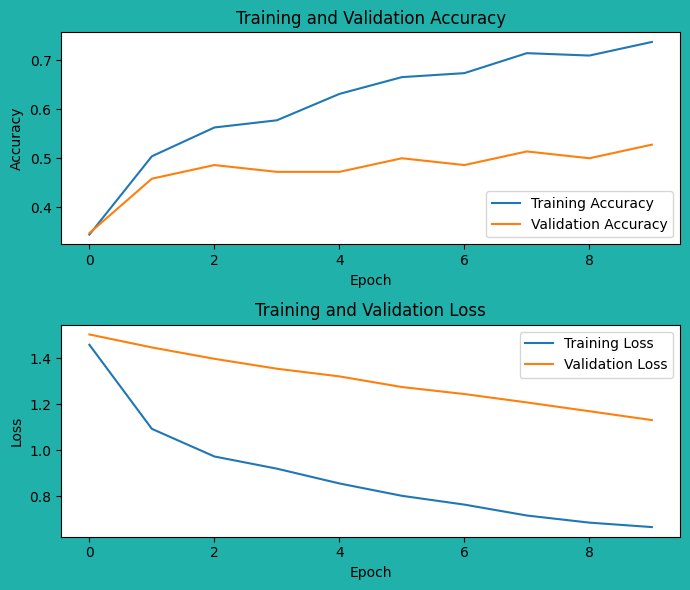

In [62]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = vgg16_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc = vgg16_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['VGG16', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, vgg16_time])
pretrained_performance_test.append(['VGG16', test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc, vgg16_time])

print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {vgg16_time}')

performance_plot(vgg16_history)

### ResNet50 Model

In [63]:
rn50 = ResNet50(include_top = False,
              input_shape = (256, 256, 3),
              weights="imagenet",
              classes=4,
              pooling = 'avg',
              classifier_activation="softmax",
              name="rn50")

rn50_model = base_model(rn50)

start_time = time.time()
rn50_history = train_model(rn50_model, train_set, val_set)
rn50_time = time.time() - start_time

Pre-trained model: (None, 2048)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,858,692 (91.01 MB)

 Trainable params: 266,884 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4007 - auc: 0.7041 - f1_score: 0.4007 - loss: 1.2476 - precision: 0.5439 - recall: 0.1824 - val_accuracy: 0.2083 - val_auc: 0.5243 - val_f1_score: 0.2083 - val_loss: 1.5003 - val_precision: 0.2558 - val_recall: 0.1528
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5672 - auc: 0.8227 - f1_score: 0.5672 - loss: 0.9512 - precision: 0.7313 - recall: 0.2772 - val_accuracy: 0.4167 - val_auc: 0.6123 - val_f1_score: 0.4167 - val_loss: 1.4204 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5840 - auc: 0.8452 - f1_score: 0.5840 - loss: 0.8692 - precision: 0.6837 - recall: 0.3532 - val_accuracy: 0.4306 - val_auc: 0.5994 - val_f1_score: 0.4306 - val_loss: 1.3985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6381 - auc: 0.8656 - f1_score: 0.6381 - loss: 0.8337 - precision: 0.7091 -

Validation Loss: 1.20 | Test Loss: 1.10
Validation Accuracy: 45.83% | Test Accuracy: 55.24%
Train Time: 453.3783812522888


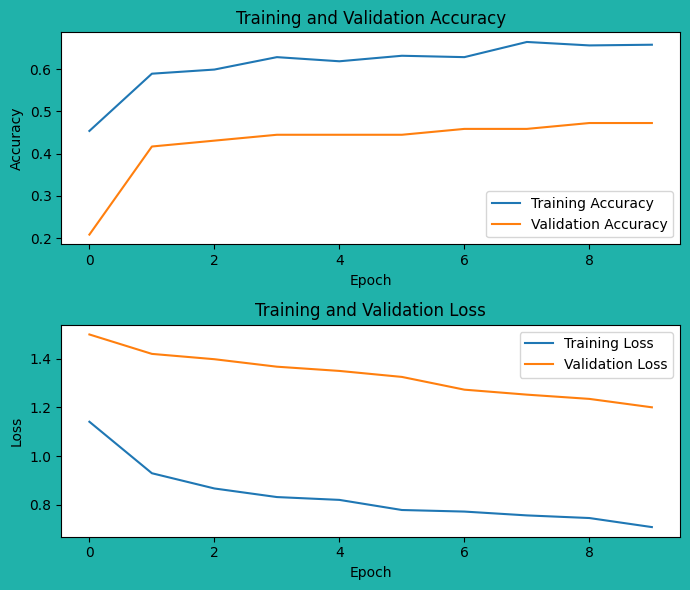

In [64]:
val_loss, val_accuracy, val_precision, val_recall,f1_val, val_auc = rn50_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc = rn50_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['ResNet50', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, rn50_time])
pretrained_performance_test.append(['ResNet50', test_loss, test_accuracy, test_precision, test_recall, f1_train, test_auc, rn50_time])

print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {rn50_time}')

performance_plot(rn50_history)

### InceptionV3 Model

In [65]:
inv3 = InceptionV3(include_top = False,
              input_shape = (256, 256, 3),
              weights="imagenet",
              classes=4,
              classifier_activation="softmax",
              name="inv3")

inv3_model = base_model(inv3)

start_time = time.time()
inv3_history = train_model(inv3_model, train_set, val_set)
inv3_time = time.time() - start_time

Pre-trained model: (None, 6, 6, 2048)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 127, 127, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 127, 127, 32)      │              96 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 127, 127, 32)      │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 125, 125, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 125, 125, 32)      │              96 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 125, 125, 32)      │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 125, 125, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 125, 125, 64)      │             192 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 125, 125, 64)      │               0 │ batch_normalization_14[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 62, 62, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 62, 62, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 62, 62, 80)        │             240 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 62, 62, 80)        │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 60, 60, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,535,524 (120.30 MB)

 Trainable params: 9,585,284 (36.56 MB)

 Non-trainable params: 21,950,240 (83.73 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5479 - auc: 0.7823 - f1_score: 0.5479 - loss: 1.3328 - precision: 0.5787 - recall: 0.5107

20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5529 - auc: 0.7863 - f1_score: 0.5529 - loss: 1.3235 - precision: 0.5835 - recall: 0.5165 - val_accuracy: 0.6944 - val_auc: 0.9140 - val_f1_score: 0.6944 - val_loss: 0.7535 - val_precision: 0.7344 - val_recall: 0.6528
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8463 - auc: 0.9673 - f1_score: 0.8463 - loss: 0.4690 - precision: 0.8508 - recall: 0.8463 - val_accuracy: 0.6944 - val_auc: 0.8675 - val_f1_score: 0.6944 - val_loss: 1.4963 - val_precision: 0.6901 - val_recall: 0.6806
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9203 - auc: 0.9799 - f1_score: 0.9203 - loss: 0.3210 - precision: 0.9232 - recall: 0.9203 - val_accuracy: 0.6944 - val_auc: 0.9257 - val_f1_score: 0.6944 - val_loss: 0.8335 - val_precision: 0.7042 - val_recall: 0.6944
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9586 - auc: 0.9964 - f1_score: 0.9586 - loss: 0.1329 - precision: 0.9583 - recall: 0.9508

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9582 - auc: 0.9964 - f1_score: 0.9582 - loss: 0.1340 - precision: 0.9580 - recall: 0.9506 - val_accuracy: 0.8889 - val_auc: 0.9761 - val_f1_score: 0.8889 - val_loss: 0.3752 - val_precision: 0.8873 - val_recall: 0.8750
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9573 - auc: 0.9942 - f1_score: 0.9573 - loss: 0.1735 - precision: 0.9573 - recall: 0.9560 - val_accuracy: 0.7778 - val_auc: 0.9525 - val_f1_score: 0.7778 - val_loss: 0.6709 - val_precision: 0.7971 - val_recall: 0.7639
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9779 - auc: 0.9975 - f1_score: 0.9779 - loss: 0.0801 - precision: 0.9779 - recall: 0.9779 - val_accuracy: 0.8056 - val_auc: 0.9450 - val_f1_score: 0.8056 - val_loss: 0.6178 - val_precision: 0.8169 - val_recall: 0.8056
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9766 - auc: 0.9992 - f1_score: 0.9766 - loss: 0.0573 - precision: 0.9766 - recall: 0.9766 - val_accur

Validation Loss: 0.49 | Test Loss: 1.08
Validation Accuracy: 84.72% | Test Accuracy: 68.89%
Train Time: 223.46447229385376


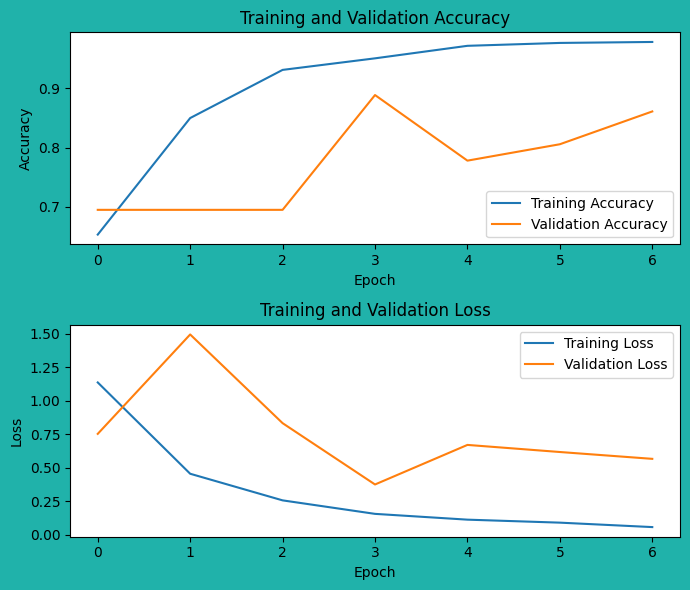

In [66]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = inv3_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc = inv3_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['InceptionV3', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, inv3_time])
pretrained_performance_test.append(['InceptionV3', test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc, inv3_time])

print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {inv3_time}')

performance_plot(inv3_history)

### DenseNet121 Model

In [67]:
dn121 = DenseNet121(include_top = False,
              input_shape = (256, 256, 3),
              weights="imagenet",
              classes=4,
              classifier_activation="softmax",
              name="dn121")

dn121_model = base_model(dn121)

start_time = time.time()
dn121_history = train_model(dn121_model, train_set, val_set)
dn121_time = time.time() - start_time

Pre-trained model: (None, 8, 8, 1024)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 262, 262, 3)       │               0 │ input_layer_7[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 64, 64, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 64, 64, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 64, 64, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 15,688,900 (59.85 MB)

 Trainable params: 8,520,324 (32.50 MB)

 Non-trainable params: 7,168,576 (27.35 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.6005 - auc: 0.8365 - f1_score: 0.6005 - loss: 0.9801 - precision: 0.6695 - recall: 0.5374 - val_accuracy: 0.6528 - val_auc: 0.8773 - val_f1_score: 0.6528 - val_loss: 1.1004 - val_precision: 0.6765 - val_recall: 0.6389
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.9357 - auc: 0.9955 - f1_score: 0.9357 - loss: 0.1538 - precision: 0.9422 - recall: 0.9281 - val_accuracy: 0.8611 - val_auc: 0.9483 - val_f1_score: 0.8611 - val_loss: 0.5422 - val_precision: 0.8571 - val_recall: 0.8333
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9829 - auc: 0.9981 - f1_score: 0.9829 - loss: 0.0636 - precision: 0.9860 - recall: 0.9829 - val_accuracy: 0.7917 - val_auc: 0.9521 - val_f1_score: 0.7917 - val_loss: 0.5612 - val_precision: 0.8143 - val_recall: 0.7917
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9806 - auc: 0.9988 - f1_score: 0.9806 - loss: 0.0615 - precision: 0.9805 - recall: 0.9786 

20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9919 - auc: 0.9996 - f1_score: 0.9919 - loss: 0.0381 - precision: 0.9919 - recall: 0.9884 - val_accuracy: 0.9028 - val_auc: 0.9768 - val_f1_score: 0.9028 - val_loss: 0.3434 - val_precision: 0.9130 - val_recall: 0.8750
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9961 - auc: 0.9976 - f1_score: 0.9961 - loss: 0.0423 - precision: 0.9965 - recall: 0.9961 - val_accuracy: 0.8472 - val_auc: 0.9695 - val_f1_score: 0.8472 - val_loss: 0.4941 - val_precision: 0.8571 - val_recall: 0.8333
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9876 - auc: 0.9993 - f1_score: 0.9876 - loss: 0.0341 - precision: 0.9890 - recall: 0.9876 - val_accuracy: 0.8889 - val_auc: 0.9797 - val_f1_score: 0.8889 - val_loss: 0.4018 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9928 - auc: 1.0000 - f1_score: 0.9928 - loss: 0.0158 - precision: 0.9934 - recall: 0.9927

20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9928 - auc: 1.0000 - f1_score: 0.9928 - loss: 0.0159 - precision: 0.9934 - recall: 0.9926 - val_accuracy: 0.8889 - val_auc: 0.9810 - val_f1_score: 0.8889 - val_loss: 0.3134 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9922 - auc: 0.9999 - f1_score: 0.9922 - loss: 0.0247 - precision: 0.9938 - recall: 0.9922 - val_accuracy: 0.8750 - val_auc: 0.9553 - val_f1_score: 0.8750 - val_loss: 0.5102 - val_precision: 0.8750 - val_recall: 0.8750


Validation Loss: 0.27 | Test Loss: 0.59
Validation Accuracy: 88.89% | Test Accuracy: 80.63%
Train Time: 550.728315114975


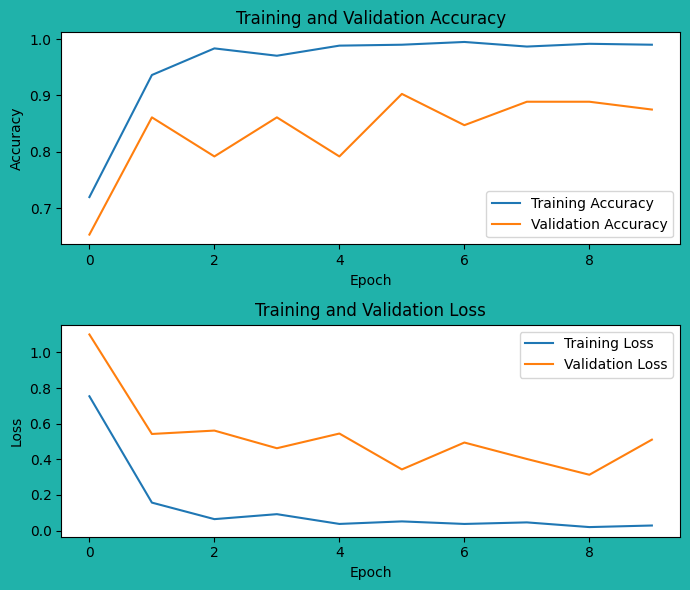

In [68]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = dn121_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc = dn121_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['DenseNet121', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, dn121_time])
pretrained_performance_test.append(['DenseNet121', test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc, dn121_time])


print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {dn121_time}')

performance_plot(dn121_history)

### ConvNeXtTiny Model

In [69]:
convnextXL = ConvNeXtTiny(include_top = False,
              input_shape = (256, 256, 3),
              weights="imagenet",
              classes=4,
              classifier_activation="softmax")

convnextXL_model = base_model(convnextXL)

start_time = time.time()
convnextXL_history = train_model(convnextXL_model, train_set, val_set)
convnextXL_time = time.time() - start_time

Pre-trained model: (None, 8, 8, 768)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_prestem_normal… │ (None, 256, 256, 3)       │               0 │ input_layer_8[0][0]        │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stem            │ (None, 64, 64, 96)        │           4,896 │ convnext_tiny_prestem_nor… │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │           4,800 │ convnext_tiny_stem[0][0]   │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │             192 │ convnext_tiny_stage_0_blo… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 384)       │          37,248 │ convnext_tiny_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 384)       │               0 │ convnext_tiny_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │          36,960 │ convnext_tiny_stage_0_blo… │
│ (Dense)                       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │              96 │ convnext_tiny_stage_0_blo… │
│ (LayerScale)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │               0 │ convnext_tiny_stage_0_blo… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_24 (Add)                  │ (None, 64, 64, 96)        │               0 │ convnext_tiny_stem[0][0],  │
│                               │                           │                 │ convnext_tiny_stage_0_blo… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ convnext_tiny_stage_0_block_… │ (None, 64, 64, 96)        │           4,800 │ add_24[0][0]               │
│ (Conv2D)                      │                           │               

 Total params: 34,308,836 (130.88 MB)

 Trainable params: 6,390,404 (24.38 MB)

 Non-trainable params: 27,918,432 (106.50 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 207s 10s/step - accuracy: 0.4800 - auc: 0.7715 - f1_score: 0.4800 - loss: 1.5471 - precision: 0.5064 - recall: 0.4461 - val_accuracy: 0.4167 - val_auc: 0.7419 - val_f1_score: 0.4167 - val_loss: 1.6285 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 200s 10s/step - accuracy: 0.7083 - auc: 0.9044 - f1_score: 0.7083 - loss: 0.9453 - precision: 0.7175 - recall: 0.7044 - val_accuracy: 0.4444 - val_auc: 0.7810 - val_f1_score: 0.4444 - val_loss: 1.3677 - val_precision: 0.4571 - val_recall: 0.4444
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.7458 - auc: 0.9420 - f1_score: 0.7458 - loss: 0.6303 - precision: 0.7593 - recall: 0.7322 - val_accuracy: 0.4722 - val_auc: 0.8130 - val_f1_score: 0.4722 - val_loss: 1.1302 - val_precision: 0.4776 - val_recall: 0.4444
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.8317 - auc: 0.9587 - f1_score: 0.8317 - loss: 0.4679 - precision: 0.8468 - recall: 0

Validation Loss: 0.76 | Test Loss: 0.92
Validation Accuracy: 69.44% | Test Accuracy: 53.65%
Train Time: 1909.026286125183


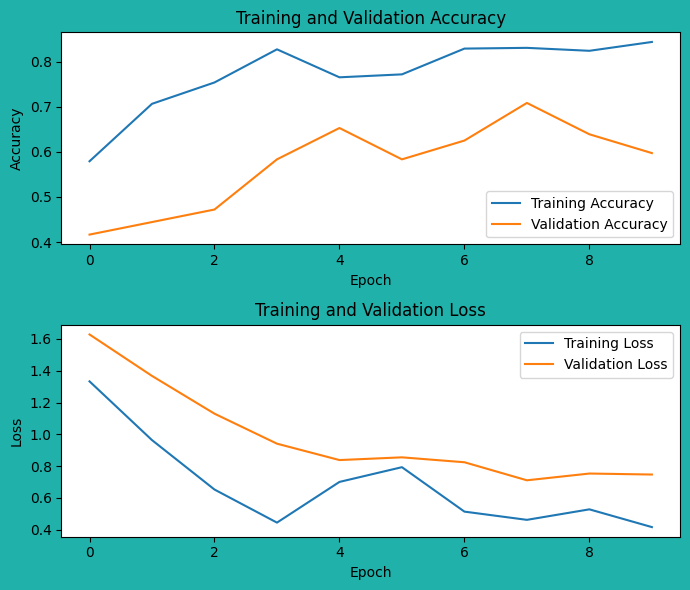

In [70]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = convnextXL_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc = convnextXL_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['ConvNeXtTiny', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, convnextXL_time])
pretrained_performance_test.append(['ConvNeXtTiny', test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc, convnextXL_time])


print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {convnextXL_time}')

performance_plot(convnextXL_history)

### EfficientNetV2L Model

In [73]:
efnV2L = EfficientNetV2L(include_top = False,
              input_shape = (256, 256, 3),
              weights="imagenet",
              classes=4,
              classifier_activation="softmax")

efnV2L_model = base_model(efnV2L)

start_time = time.time()
efnV2LL_history = train_model(efnV2L_model, train_set, val_set)
efnV2L_time = time.time() - start_time

Pre-trained model: (None, 8, 8, 1280)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 32)      │             864 │ rescaling_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 128, 128, 32)      │           9,216 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 128, 128, 32)      │             128 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 128, 128, 32)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 128, 128, 32)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 128, 128, 32)      │           9,216 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 128, 128, 32)      │             128 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 128, 128, 32)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 128, 128, 32)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 128, 128, 32)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 128,560,932 (490.42 MB)

 Trainable params: 10,650,244 (40.63 MB)

 Non-trainable params: 117,910,688 (449.79 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 230s 9s/step - accuracy: 0.4208 - auc: 0.6633 - f1_score: 0.4208 - loss: 2.7692 - precision: 0.4497 - recall: 0.3662 - val_accuracy: 0.2083 - val_auc: 0.5144 - val_f1_score: 0.2083 - val_loss: 6.5268 - val_precision: 0.2083 - val_recall: 0.2083
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.4622 - auc: 0.7202 - f1_score: 0.4622 - loss: 2.3502 - precision: 0.4658 - recall: 0.4395 - val_accuracy: 0.1806 - val_auc: 0.4667 - val_f1_score: 0.1806 - val_loss: 3.3020 - val_precision: 0.1831 - val_recall: 0.1806
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.5766 - auc: 0.7749 - f1_score: 0.5766 - loss: 2.8890 - precision: 0.5963 - recall: 0.5569 - val_accuracy: 0.2917 - val_auc: 0.5095 - val_f1_score: 0.2917 - val_loss: 5.0277 - val_precision: 0.2917 - val_recall: 0.2917
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.5776 - auc: 0.8084 - f1_score: 0.5776 - loss: 1.8630 - precision: 0.5806 - recall: 0.5

Validation Loss: 1.28 | Test Loss: 1.49
Validation Accuracy: 37.50% | Test Accuracy: 43.81%
Train Time: 1760.908802986145


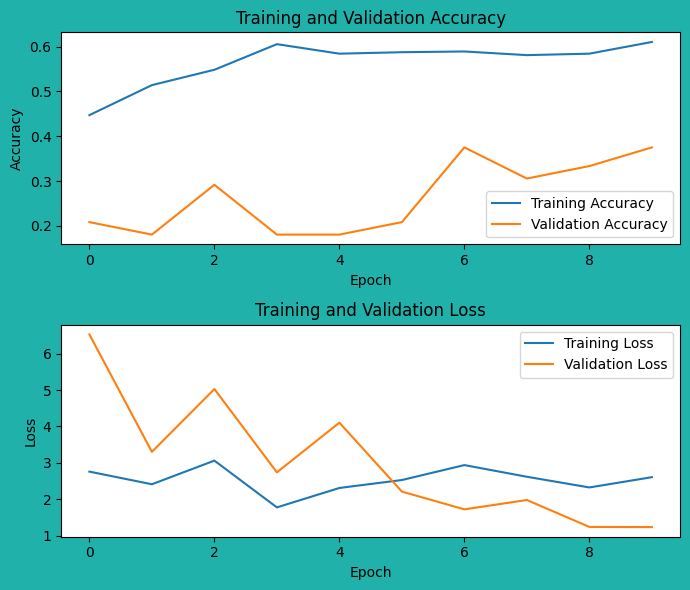

In [74]:
val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc = efnV2L_model.evaluate(val_set, verbose=0)
test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc = efnV2L_model.evaluate(test_set, verbose=0)

pretrained_performance_val.append(['EfficientNetV2L', val_loss, val_accuracy, val_precision, val_recall, f1_val, val_auc, efnV2L_time])
pretrained_performance_test.append(['EfficientNetV2L', test_loss, test_accuracy, test_precision, test_recall, f1_test, test_auc, efnV2L_time])


print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Train Time: {efnV2L_time}')

performance_plot(efnV2LL_history)

# Metrics Summary

In [75]:
col = ['Model', 'Loss','Accuracy', 'Precision','Recall','F1-score', 'AUC', 'Time (s)']
df_performance_val = pd.DataFrame(pretrained_performance_val, columns = col)
df_performance_test = pd.DataFrame(pretrained_performance_test, columns = col)

In [76]:
print(f'* * * Pre-trained Models performance on the Validation Set * * *\n')
df_performance_val.sort_values(by='F1-score', ascending = False)

* * * Pre-trained Models performance on the Validation Set * * *



Model      Loss  Accuracy  Precision    Recall  F1-score  \
4      DenseNet121  0.269829  0.888889   0.888889  0.888889  0.888889   
3      InceptionV3  0.486554  0.847222   0.869565  0.833333  0.847222   
0         Xception  0.862665  0.736111   0.820513  0.444444  0.736111   
5     ConvNeXtTiny  0.755400  0.694444   0.777778  0.388889  0.694444   
1            VGG16  1.141705  0.513889   1.000000  0.125000  0.513889   
2         ResNet50  1.196339  0.458333   1.000000  0.138889  0.458333   
6  EfficientNetV2L  1.283070  0.375000   0.440678  0.361111  0.375000   

        AUC     Time (s)  
4  0.987494   550.728315  
3  0.962770   223.464472  
0  0.887442   500.057818  
5  0.898341  1909.026286  
1  0.806263   883.596970  
2  0.749196   453.378381  
6  0.727366  1760.908803

In [77]:
print(f'* * * Pre-trained Models performance on the Test Set * * *\n')
df_performance_test.sort_values(by='F1-score', ascending = False)

* * * Pre-trained Models performance on the Test Set * * *



Model      Loss  Accuracy  Precision    Recall  F1-score  \
4      DenseNet121  0.594335  0.806349   0.820598  0.784127  0.806349   
3      InceptionV3  1.078107  0.688889   0.694631  0.657143  0.688889   
0         Xception  0.864919  0.660317   0.793750  0.403175  0.660317   
2         ResNet50  1.096736  0.552381   1.000000  0.114286  0.552381   
1            VGG16  1.166143  0.549206   1.000000  0.098413  0.549206   
5     ConvNeXtTiny  0.916003  0.536508   0.670807  0.342857  0.536508   
6  EfficientNetV2L  1.486738  0.438095   0.463320  0.380952  0.438095   

        AUC     Time (s)  
4  0.945768   550.728315  
3  0.890617   223.464472  
0  0.889744   500.057818  
2  0.803391   453.378381  
1  0.793878   883.596970  
5  0.838579  1909.026286  
6  0.628432  1760.908803

In [96]:
%reload_ext tensorboard
%tensorboard --logdir logs

# Prediction 

In [105]:
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256), 
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)

Found 315 images belonging to 4 classes.


In [106]:
def summary_model(model):
    y_true = test_generator.classes  # Це числові мітки
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
    print("Classification Report:")
    print(classification_report(y_true, y_pred_labels, zero_division = 0))

    cm = confusion_matrix(y_true, y_pred_labels)
    print("Confusion Matrix:")
    print(cm)
    
    # plot confusion matrix
    sns.heatmap(cm, annot=True, cmap="BuGn", fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [107]:
def prediction_plot(model):
    # Get class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Predict on each image and plot results
    plt.figure(figsize=(10, 10), facecolor='lightseagreen')
    
    image, label = next(test_generator)
    
    for i in range(20):
        prediction = model.predict(np.expand_dims(image[i], axis=0), verbose=0)
        
        predicted_class = class_labels[np.argmax(prediction)]
        true_class = class_labels[np.argmax(label[i])]
        
        plt.subplot(5, 4, i + 1)
        plt.imshow(image[i])
        plt.title(f'True: {true_class}\nPred: {predicted_class}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### The Best Model

In [108]:
# loaded_model = load_model(checkpoint_filepath)
# dn121_model.load_weights("best_model.h5")

C:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.41      0.57       120
           1       0.79      0.90      0.84        51
           2       0.90      0.98      0.94        54
           3       0.58      0.94      0.72        90

    accuracy                           0.74       315
   macro avg       0.80      0.81      0.77       315
weighted avg       0.81      0.74      0.72       315

Confusion Matrix:
[[49  9  4 58]
 [ 0 46  2  3]
 [ 0  1 53  0]
 [ 3  2  0 85]]


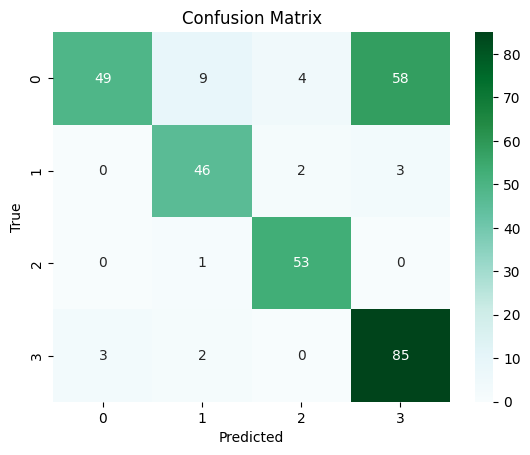

In [109]:
summary_model(dn121_model)

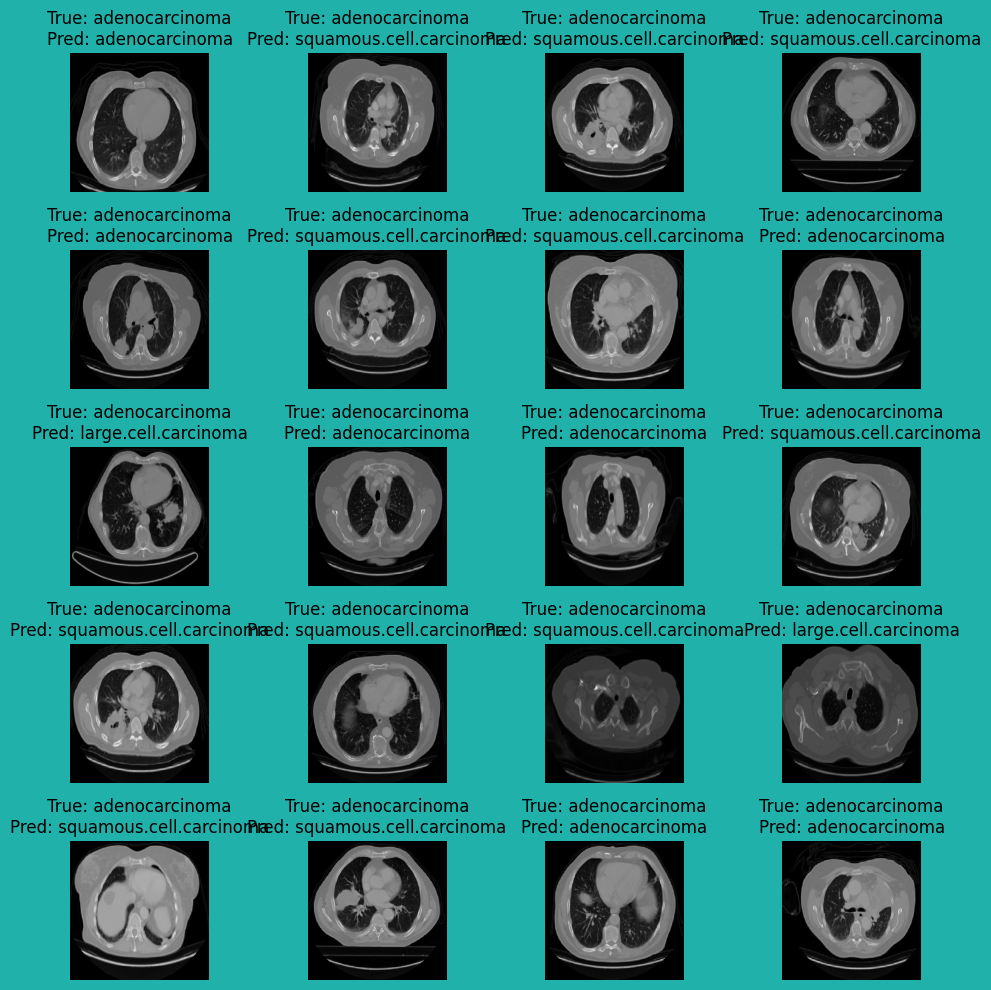

In [110]:
prediction_plot(dn121_model)

### The Worst Model 

10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00        51
           2       0.59      0.94      0.73        54
           3       0.35      0.90      0.51        90

    accuracy                           0.42       315
   macro avg       0.24      0.46      0.31       315
weighted avg       0.20      0.42      0.27       315

Confusion Matrix:
[[  0   0  20 100]
 [  0   0   6  45]
 [  0   0  51   3]
 [  0   0   9  81]]


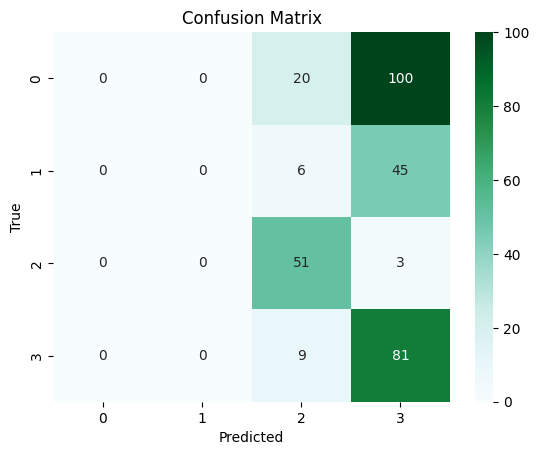

In [111]:
summary_model(efnV2L_model)

In [112]:
from sklearn.metrics import confusion_matrix, auc, f1_score

In [142]:
y_pred_proba = rn50_model.predict(test_set)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
y_true = []

for img, labels in test_set:
    y_true.extend(np.argmax(labels, axis=1)) 
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


KeyboardInterrupt: 

In [ ]:
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256), 
    batch_size=1,
    class_mode='categorical', 
    shuffle=True
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on each image and plot results
num_images = 20
plt.figure(figsize=(10, 10), facecolor='aliceblue')
for i in range(num_images):
    image, label = next(test_generator)
    prediction = final_cnn.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    true_class = class_labels[np.argmax(label)]
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(image[0])
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model_base, model_history, test_set, val_set):
    evaluation = []
    val_loss, val_accuracy, val_precision, val_recall, val_auc = model_base.evaluate(val_set, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_base.evaluate(test_set, verbose=0)
    evaluation.append([val_loss, val_accuracy, val_precision, val_recall, val_auc,
                       test_loss, test_accuracy, test_precision, test_recall, test_auc])
    
    print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
    print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')
    
    performance_plot(model_history)

    return evaluation

In [ ]:
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256), 
    batch_size=1,
    class_mode='categorical', 
    shuffle=True
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on each image and plot results
num_images = 20
plt.figure(figsize=(10, 10), facecolor='aliceblue')
for i in range(num_images):
    image, label = next(test_generator)
    prediction = final_cnn.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    true_class = class_labels[np.argmax(label)]
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(image[0])
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [166]:
from keras.src.metrics.confusion_metrics import activations
modelxc = Sequential()
modelxc.add(xc)
modelxc.add(BatchNormalization())
modelxc.add(MaxPooling2D((2,2)))
modelxc.add(Flatten())
modelxc.add(Dense(1024,activation = 'relu'))
modelxc.add(Dropout(0.3))
modelxc.add(Dense(512,activation = 'relu'))
modelxc.add(Dropout(0.3))
modelxc.add(Dense(256,activation = 'relu'))
modelxc.add(Dense(128,activation = 'relu'))
modelxc.add(Dense(4,activation = 'softmax'))
modelxc.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 8, 8, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,114,668 (210.25 MB)

 Trainable params: 34,249,092 (130.65 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

 Total params: 55,114,668 (210.25 MB)
 Trainable params: 34,249,092 (130.65 MB)
 Non-trainable params: 20,865,576 (79.60 MB)

In [168]:
modelxc.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5),
#     tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
# ]


results = modelxc.fit(
    train_set,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch  = len(train_set),
    class_weight = cls_wgts,
    callbacks = [early_stopping, model_checkpoint],
    verbose = 1,
    epochs = 25)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4336 - loss: 5.4754 - val_accuracy: 0.4583 - val_loss: 0.9730
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5270 - loss: 2.2922 - val_accuracy: 0.4861 - val_loss: 0.9358
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6223 - loss: 1.1548 - val_accuracy: 0.5278 - val_loss: 0.9095
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6425 - loss: 0.9883 - val_accuracy: 0.5000 - val_loss: 0.9260
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6659 - loss: 0.7808 - val_accuracy: 0.6806 - val_loss: 0.8012
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7417 - loss: 0.5850 - val_accuracy: 0.6389 - val_loss: 0.7806
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7927 - loss: 0.5504 - val_accuracy: 0.6389 - val_loss: 0.7462
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8425 - loss: 0.3288 - val_accuracy: 0.5972 - val_loss:

Validation Loss: 0.57 | Test Loss: 0.71
Validation Accuracy: 70.83% | Test Accuracy: 69.21%


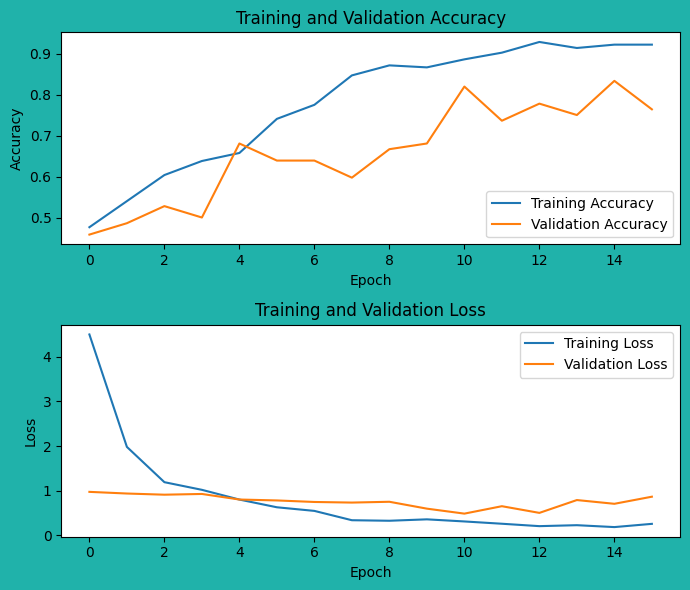

In [170]:
val_loss, val_accuracy = modelxc.evaluate(val_set, verbose=0)
test_loss, test_accuracy = modelxc.evaluate(test_set, verbose=0)

print(f'Validation Loss: {val_loss:.2f} | Test Loss: {test_loss:.2f}')
print(f'Validation Accuracy: {100 * val_accuracy:.2f}% | Test Accuracy: {100 * test_accuracy:.2f}%')

performance_plot(results)

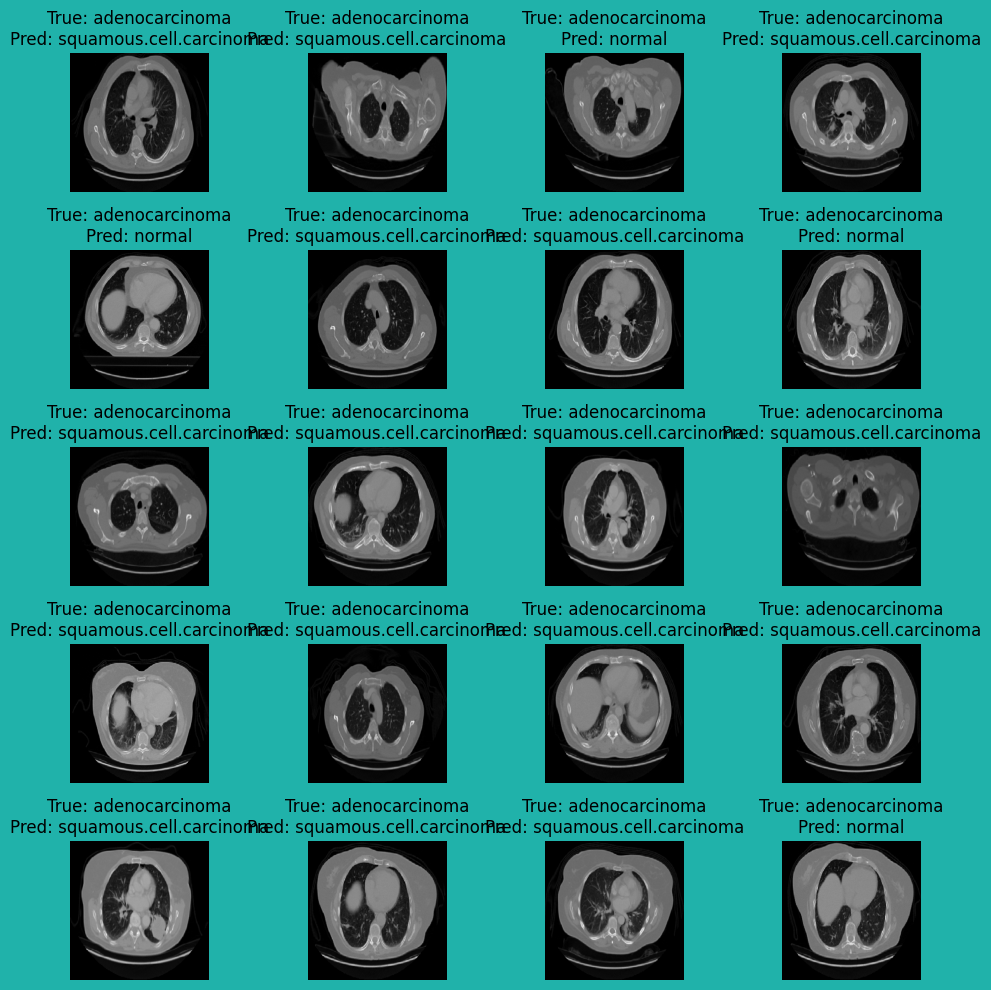

In [113]:
prediction_plot(efnV2L_model)

### **Conclusion:**
The transfer learning technology was used to build a model of convolutional neural networks for the purpose of classifying three types of cancer (Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma) on CT-Scan images.
The work consists of two parts:
* Building a CNN model with several convolutional layers and max-pooling layers.
* Building deep models with pre-trained weights on the ImageNet image set, namely: Xception, VGG16, ResNet50, InceptionV3, DenseNet121, ConvNeXtTiny, EfficientNetV2L.

During training, pre-trained weights were frozen for the models. After that, quality assessments were calculated for each of the models: loss value, accuracy, precision, recall, F1-score, AUC, training time, and graphs of changes in the loss function and accuracy index during training. The best model was selected based on the F1-score metric. Training was also performed for 10 epochs, with early stopping based on the loss quality indicator.

As a result, the best behavior was shown by the **DenseNet121** architecture, where:
* Validation Loss: 0.269829 | Test Loss: 0.594335
* Validation F1-score: 0.888889 | Test F1-score: 0.806349
* Validation Accuracy: 0.888889 | Test Accuracy: 0.806349
* Validation Precision: 0.888889 | Test Precision: 0.820598
* Validation Recall: 0.888889 | Test Recall: 0.784127
* Validation AUC: 0.987494 | Test Precision:0.945768
* Time (s): 550.7

The worst behavior was shown by the **EfficientNetV2L** architecture, where:
* Validation Loss: 1.283070| Test Loss: 1.486738
* Validation F1-score: 0.375000 | Test F1-score Loss: 0.438095
* Validation Accuracy: 0.375000 | Test Accuracy: 0.438095
* Validation Precision: 0.440678 | Test Precision: 0.463320
* Validation Recall: 0.361111 | Test Recall: 0.380952
* Validation AUC: 0.727366 | Test Precision:0.628432
* Time (s): 1760.9

In addition, the metrics of the models **InceptionV3, Xception** also had better results on both the validation and test sets.

While the metrics of the own convolutional network **cnn_model** are as follows:
* Early stopping after 13 epochs.
* Validation Loss: 0.704173
* Validation F1-score: 0.736111
* Validation Accuracy: 0.736111
* Validation Precision: 0.761905
* Validation Recall: 0.666667
* Validation AUC: 0.912166
* Time (s): 445.63

It can be seen that the best model makes the most errors for images of class "0", classifying them as "3". While the worst model did not classify the first two classes at all.